In [71]:
! [ -e /content ] && pip install -Uqq fastbook

In [72]:
import fastbook
fastbook.setup_book()
from fastai.vision.all import *
from fastbook import *

In [73]:
matplotlib.rc('image', cmap='Greys')

For the purpose of this notebook, I'm going to try to create a model that can classify any images as 3 or a 7.

In [74]:
path = untar_data(URLs.MNIST_SAMPLE)

In [75]:
Path.BASE_PATH = path

In [76]:
path.ls()

(#3) [Path('train'),Path('labels.csv'),Path('valid')]

It follows a common layout for machine learning datasets: separate folders for the training set and the validation set (and / or test set)

In [77]:
(path/'train').ls()

(#2) [Path('train/3'),Path('train/7')]

In [78]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()

In [79]:
threes

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png')...]

In [80]:
single_im3_path = threes[1]
single_im3 = Image.open(single_im3_path)
single_im3

In [81]:
im3 = single_im3

In [82]:
array(im3)[4:10, 4:10] # we're requesting the rows from index 4 (included) to 10 (not included)

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

In [83]:
tensor(im3)[4:10][4:10]

tensor([[  0,   0,   0,   0,   0, 107, 253, 253, 230,  48,   0,   0,   0,   0,   0, 192, 253, 253, 156,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   3,  20,  20,  15,   0,   0,   0,   0,   0,  43, 224, 253, 245,  74,   0,   0,   0,   0,   0,   0,   0,   0,   0]], dtype=torch.uint8)

In [84]:
im3_t = tensor(im3)

In [85]:
df = pd.DataFrame(im3_t[4:15, 4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


MNIST images contain 28 pixels across and 28 pixels down, for a total of 784 pixels.

#### First Try: Pixel Similarity

Idea: we find the average pixel value for every pixel of the 3s,
then do the same for the 7s. This will give us two group averages,
defining what we might call the "ideal" 3 and 7. 
Then, to classify an image as one digit or the other, we see which of these two ideal digits the image is most similar to. This certainly seems like it should be better than nothing, so it will make a good baseline.


In [86]:
# step 1: get the average of pixel values for each of our two groups
# lets create a tensor containing all of our 3s stacked together.

In [87]:
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors), len(seven_tensors)

(6131, 6265)

In [88]:
# step 2: for every pixel position, we want to compute the average
# over all the images of the intensity of that pixel. To do this we
# combinte all the images in the list into a single 3d tensor. 
# We often need to stack up individual tensors in a collection
# into a single tensor.

In [89]:
stacked_sevens = torch.stack(seven_tensors).float() / 255 # norm

In [90]:
stacked_threes = torch.stack(three_tensors).float() / 255 # norm (pixels only)

In [91]:
stacked_threes.shape # 6131 images, each of size 28x28

torch.Size([6131, 28, 28])

In [92]:
# The length of a tensor's shape is its rank:
len(stacked_threes.shape)
# rank is the number of axes or dimensions in a tensor; shape is the size of each axis of a tensor

3

In [93]:
# step 3: calculations

In [94]:
mean3 = stacked_threes.mean(0)

<AxesSubplot:>

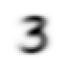

In [95]:
show_image(mean3)

In [96]:
mean7 = stacked_sevens.mean(0) #axis 0, mean across all images

<AxesSubplot:>

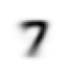

In [97]:
show_image(mean7)

There are two main ways DSists measure distance in this context:
- take the mean of the avsolute value of differences. This is called the mean absolute difference or L1 norm
- take the mean of the square of differences (which makes everything positive) and then take the square root (which undoes the squaring). This is called the root mean squared error (RMSE) or L2 norm

In [98]:
# Let's now pick an arbitrary 3 and measure its distance from our "ideal digits."
a_3 = stacked_threes[1]

In [99]:
dist_3_abs = (a_3 - mean3).abs().mean()
dist_3_sqr = ((a_3 - mean3) ** 2).mean().sqrt()
dist_3_abs, dist_3_sqr

(tensor(0.1114), tensor(0.2021))

In [100]:
dist_7_abs = (a_3 - mean7).abs().mean()
dist_7_sqr = ((a_3 - mean7) ** 2).mean().sqrt()
dist_7_abs, dist_7_sqr

(tensor(0.1586), tensor(0.3021))

In both cases, the distance between our 3 and the "ideal" 3 is less than the distance to the ideal 7. So our simple model will give the right prediction in this case.

PyTorch already provides both of these as loss functions. You'll find these inside torch.nn.functional, which the PyTorch team recommends importing as F (and is available by default under that name in fastai):

In [101]:
F.l1_loss(a_3.float(), mean7), F.mse_loss(a_3, mean7).sqrt()

(tensor(0.1586), tensor(0.3021))

Intuitively, the difference between L1 norm and mean squared error (MSE) is that the latter will penalize bigger mistakes more heavily than the former (and be more lenient with small mistakes).


### Tensors

In [102]:
data = [[1,2,3],[4,5,6]]

In [103]:
arr = array(data) # numpy
tns = tensor(data) # pytorch

In [105]:
arr, tns

(array([[1, 2, 3],
        [4, 5, 6]]),
 tensor([[1, 2, 3],
         [4, 5, 6]]))

In [106]:
tns[1]

tensor([4, 5, 6])

In [107]:
tns[:, 1]

tensor([2, 5])

In [108]:
tns[1, 1:3]

tensor([5, 6])

In [109]:
tns+1

tensor([[2, 3, 4],
        [5, 6, 7]])

In [110]:
tns.type()

'torch.LongTensor'

In [111]:
tns*1.5

tensor([[1.5000, 3.0000, 4.5000],
        [6.0000, 7.5000, 9.0000]])

### Validation set + distance function

In [116]:
valid_3_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float() / 255

In [119]:
valid_7_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float() / 255

In [120]:
valid_3_tens.shape, valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

In [123]:
def mnist_distance(a, b):
    return (a - b).abs().mean((-1, -2))
mnist_distance(a_3, mean3)

tensor(0.1114)

In [130]:
valid_3_dist = mnist_distance(valid_3_tens, mean3) # broadcasting

In [131]:
valid_3_dist, valid_3_dist.shape

(tensor([0.1787, 0.1422, 0.1412,  ..., 0.1358, 0.1301, 0.1110]),
 torch.Size([1010]))

In [132]:
tensor(mean3).shape

torch.Size([28, 28])

In [133]:
(valid_3_tens - mean3).shape

torch.Size([1010, 28, 28])

In [134]:
def is_3(x):
    return mnist_distance(x, mean3) < mnist_distance(x, mean7)

In [135]:
is_3(a_3), is_3(a_3).float()

(tensor(True), tensor(1.))

In [136]:
is_3(valid_3_tens)

tensor([False,  True,  True,  ...,  True,  True,  True])

#### Accuracy

In [137]:
accuracy_3s = is_3(valid_3_tens).float().mean()
accuracy_7s = (1 - is_3(valid_7_tens).float()).mean()

In [138]:
accuracy_3s, accuracy_7s, (accuracy_3s + accuracy_7s) / 2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

Here are the steps that we are going to require, to turn this function into a machine learning classifier:
- initialize the weights,
- for each image, use these weights to predict whether it appears to be a 3 or a 7
- based on these predictions, calculate how good the model is (its loss)
- calculate the gradient, which measures for each weight, how changing that weight would change the loss
- step (that is, change) all the weights based on that calculation
- go back to the step 2, repeat
- iterate until you decide to stop the training process


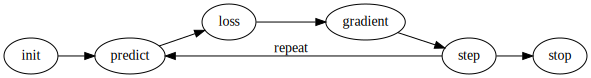

In [139]:
gv('''
init->predict->loss->gradient->step->stop
step->predict[label=repeat]
''')

In [140]:
def f(x): return x ** 2

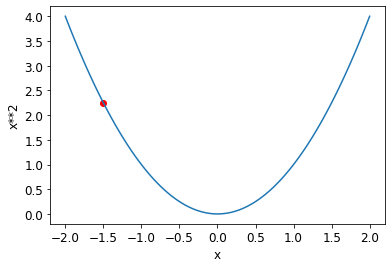

In [142]:
plot_function(f, 'x', 'x**2')
plt.scatter(-1.5, f(-1.5), color='red');

#### Calculating Gradients

In [143]:
xt = tensor(3.).requires_grad_()

In [146]:
yt = f(xt)
yt

tensor(9., grad_fn=<PowBackward0>)

In [147]:
yt.backward()

In [149]:
xt.grad

tensor(6.)

In [153]:
xt = tensor([3., 4. , 10.]).requires_grad_() #input

In [155]:
def f(x): return (x**2).sum()
yt = f(xt)
yt

tensor(125., grad_fn=<SumBackward0>)

In [156]:
yt.backward()
xt.grad

tensor([ 6.,  8., 20.])

### An End-to-End SGD Example

In [158]:
time = torch.arange(0, 20).float(); time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19.])

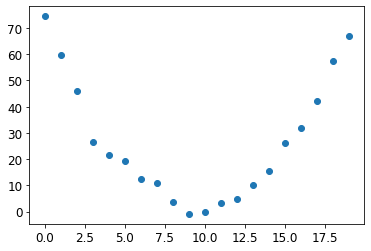

In [159]:
speed = torch.randn(20) * 3 + 0.75 * (time - 9.5) ** 2 + 1
plt.scatter(time, speed)

In [160]:
def f(t, params):
    a, b, c = params
    return a * (t**2) + (b * t) + c

In [161]:
def mse(preds, targets):
    return ((preds - targets) ** 2).mean()

In [162]:
# step 1: initialize the parameters
params = torch.randn(3).requires_grad_()
orig_params = params.clone()

In [163]:
# step 2: calculate the predictions
preds = f(time, params)

In [164]:
def show_preds(preds, ax=None):
    if ax is None: ax = plt.subplots()[1]
    ax.scatter(time, speed)
    ax.scatter(time, to_np(preds), color='red')
    ax.set_ylim(-300, 100)

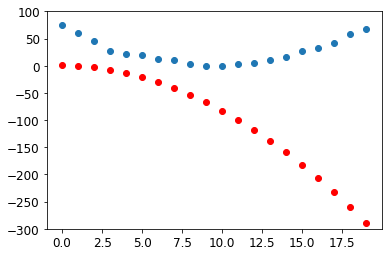

In [165]:
show_preds(preds)

This doesn't look very close—our random parameters suggest that the roller coaster will end up going backwards, since we have negative speeds!

In [166]:
# step 3: calculate the loss
loss = mse(preds, speed)
loss

tensor(25823.8086, grad_fn=<MeanBackward0>)

In [167]:
# step 4: calculate the gradients
loss.backward()
params.grad

tensor([-53195.8633,  -3419.7148,   -253.8908])

In [169]:
params.grad * 1e-5 # 0.00001 learning rate

tensor([-0.5320, -0.0342, -0.0025])

In [170]:
# step 5: step the weights
lr = 1e-5
params.data -= lr * params.grad.data
params.grad = None

In [171]:
preds = f(time, params)
mse(preds, speed)

tensor(5435.5356, grad_fn=<MeanBackward0>)

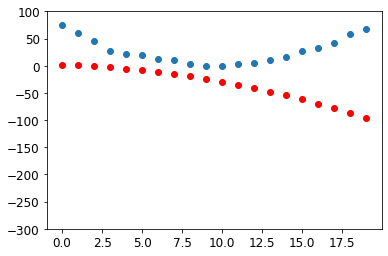

In [172]:
show_preds(preds)

In [173]:
# we need to repeat this a few times
def apply_step(params, prn=True):
    preds = f(time, params)
    loss = mse(preds, speed)
    loss.backward()
    params.data -= lr * params.grad.data
    params.grad = None
    if prn: print(loss.item())
    return preds

In [174]:
# step 6: repeat the process
for i in range(10):
    apply_step(params)

5435.53564453125
1577.44921875
847.3778076171875
709.2225341796875
683.0758056640625
678.1243896484375
677.1838989257812
677.0023803710938
676.9645385742188
676.9537353515625


In [175]:
params = orig_params.detach().requires_grad_()

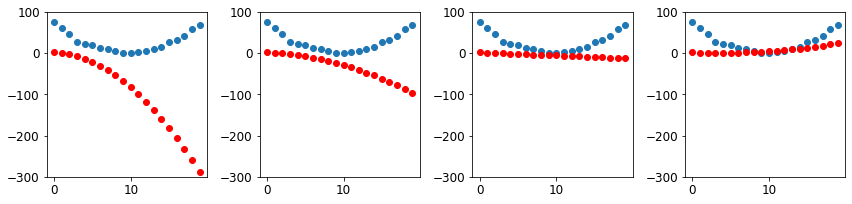

In [177]:
_, axs = plt.subplots(1, 4, figsize=(12,3))
for ax in axs: show_preds(apply_step(params, False), ax)
plt.tight_layout()

### The MNIST Loss Function

In [179]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)

In [184]:
# We need a label for each image. We'll use 1 for 3s and 0 for 7s:
train_y = tensor([1] * len(threes) + [0] * len(sevens)).unsqueeze(1)

In [183]:
train_x.shape, train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

In [185]:
dset = list(zip(train_x, train_y))
x, y = dset[0]
x.shape, y

(torch.Size([784]), tensor([1]))

In [187]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x,valid_y))

In [189]:
def init_params(size, std=1.0):
    return (torch.randn(size)*std).requires_grad_()
weights = init_params((28 * 28, 1))

In [193]:
bias = init_params(1)

In [195]:
# y=wx+b

In [196]:
(train_x[0] * weights.T).sum() + bias

tensor([19.5644], grad_fn=<AddBackward0>)

In [197]:
# In Python, matrix multiplication is represented with the @ operator. Let's try it:

In [199]:
def linear1(xb):
    return xb@weights + bias
preds = linear1(train_x)
preds

tensor([[19.5644],
        [16.3951],
        [14.5691],
        ...,
        [17.7111],
        [23.1874],
        [28.0124]], grad_fn=<AddBackward0>)

In [201]:
corrects = (preds > 0.0).float() == train_y
corrects

tensor([[ True],
        [ True],
        [ True],
        ...,
        [False],
        [False],
        [False]])

In [202]:
corrects.float().mean().item()

0.49040013551712036

In [203]:
trgts = tensor([1, 0, 1])
prds = tensor([0.9, 0.4, 0.2])

In plain English, this function will measure how distant each prediction is from 1 if it should be 1, and how distant it is from 0 if it should be 0, and then it will take the mean of all those distances.

In [209]:
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

In [210]:
torch.where(trgts==1, 1-prds, prds)

tensor([0.1000, 0.4000, 0.8000])

In [211]:
mnist_loss(prds, trgts)

tensor(0.4460)

#### Sigmoid
The *sigmoid* function always outputs a number between 0 and 1

In [212]:
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

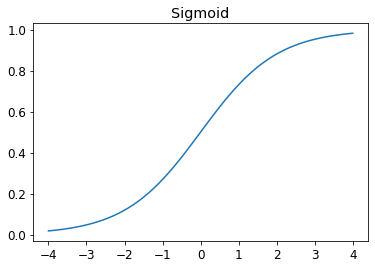

In [213]:
plot_function(torch.sigmoid, title='Sigmoid', min=-4, max=4)


In [214]:
coll = range(15)
dl = DataLoader(coll, batch_size = 5, shuffle=True)
list(dl)

[tensor([ 3, 12,  8, 10,  2]),
 tensor([ 9,  4,  7, 14,  5]),
 tensor([ 1, 13,  0,  6, 11])]

#### Putting It All Together

In [239]:
weights = init_params((28 * 28, 1))
bias = init_params(1)

In [240]:
dl = DataLoader(dset, batch_size=256)
xb, yb = first(dl) # first element from the ds
xb.shape, yb.shape # 256 img stacked, 28x28pxls, target 256,1

(torch.Size([256, 784]), torch.Size([256, 1]))

In [241]:
valid_dl = DataLoader(valid_dset, batch_size=256)

In [242]:
# lets create a mini batch of size 4 for testing
batch = train_x[:4]
batch.shape

torch.Size([4, 784])

In [243]:
preds = linear1(batch)
preds

tensor([[-3.2848],
        [ 5.5670],
        [ 3.0307],
        [ 9.5081]], grad_fn=<AddBackward0>)

In [244]:
loss = mnist_loss(preds, train_y[:4])
loss

tensor(0.2535, grad_fn=<MeanBackward0>)

In [245]:
loss.backward()
weights.grad.shape, weights.grad.mean(), bias.grad

(torch.Size([784, 1]), tensor(-0.0030), tensor([-0.0206]))

In [246]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

In [247]:
calc_grad(batch, train_y[:4], linear1)

In [248]:
weights.grad.mean(), bias.grad

(tensor(-0.0059), tensor([-0.0413]))

In [249]:
weights.grad.zero_()
bias.grad.zero_()

tensor([0.])

note: Inplace Operations: Methods in PyTorch whose names end in an underscore modify their objects in place. For instance, bias.zero_() sets all elements of the tensor bias to 0.

In [257]:
def train_epoch(model, lr, params):
    for xb, yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

In [258]:
(preds > 0.0).float() == train_y[:4]

tensor([[False],
        [ True],
        [ True],
        [ True]])

In [259]:
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds > 0.5) == yb
    return correct.float().mean()

In [260]:
batch_accuracy(linear1(batch), train_y[:4])

tensor(0.7500)

In [261]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb, yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [262]:
validate_epoch(linear1)

0.6485

In [263]:
lr = 1.
params = weights, bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.7415

In [264]:
for i in range(20):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end=' ')

0.8856 0.9261 0.9427 0.9491 0.9544 0.9593 0.9613 0.9627 0.9647 0.9657 0.9677 0.9681 0.9681 0.9686 0.9701 0.9701 0.9706 0.9725 0.9725 0.973 

### Creating an Optimizer

In [266]:
linear_model = nn.Linear(28*28, 1)

In [267]:
w, b = linear_model.parameters()
w.shape, b.shape

(torch.Size([1, 784]), torch.Size([1]))

In [268]:
class BasicOptim:
    def __init__(self, params, lr):
        self.params, self.lr = list(params), lr
    def step(self, *args, **kwargs):
        for p in self.params:
            p.data -= p.grad.data * self.lr
    def zero_grad(self, *args, **kwargs):
        for p in self.params:
            p.grad = None

In [269]:
opt = BasicOptim(linear_model.parameters(), lr)

In [274]:
def train_epoch(model):
    for xb, yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

In [275]:
validate_epoch(linear_model)

0.576

In [276]:
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=' ')

In [277]:
train_model(linear_model, 20)

0.4932 0.8101 0.8491 0.9141 0.9346 0.9478 0.9561 0.9624 0.9658 0.9673 0.9702 0.9717 0.9731 0.9746 0.9761 0.9766 0.9775 0.978 0.978 0.978 

In [278]:
linear_model = nn.Linear(28 * 28, 1)
opt = SGD(linear_model.parameters(), lr)
train_model(linear_model, 20)

0.4932 0.7993 0.8521 0.916 0.937 0.9482 0.957 0.9639 0.9663 0.9683 0.9692 0.9717 0.9736 0.9751 0.9756 0.9766 0.9775 0.978 0.978 0.9785 

In [279]:
dls = DataLoaders(dl, valid_dl)

In [281]:
learn = Learner(dls, 
                nn.Linear(28*28,1), 
                opt_func=SGD, 
                loss_func = mnist_loss, 
                metrics = batch_accuracy)

In [282]:
learn.fit(10, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.636820,0.503632,0.495584,00:00
1,0.600313,0.114744,0.926889,00:00
2,0.216882,0.220744,0.796860,00:00
3,0.093456,0.117217,0.901374,00:00
4,0.047968,0.082808,0.929833,00:00
5,0.030289,0.065361,0.943572,00:00
6,0.023075,0.054677,0.954367,00:00
7,0.019924,0.047632,0.960746,00:00
8,0.018374,0.042736,0.964671,00:00
9,0.017474,0.039167,0.966634,00:00


### Adding a Nonlinearity

In [283]:
def simple_net(xb):
    res = xb@w1 + b1
    res = res.max(tensor(0.0))
    res = res@w2 + b2
    return res

In [284]:
w1 = init_params((28*28, 30))
b1 = init_params(30)
w2 = init_params((30, 1))
b2 = init_params(1)

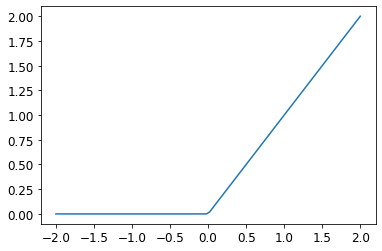

In [285]:
plot_function(F.relu)


The basic idea is that by using more linear layers, we can have our model do more computation, and therefore model more complex functions. But there's no point just putting one linear layer directly after another one, because when we multiply things together and then add them up multiple times, that could be replaced by multiplying different things together and adding them up just once! That is to say, a series of any number of linear layers in a row can be replaced with a single linear layer with a different set of parameters.

But if we put a nonlinear function between them, such as max, then this is no longer true. Now each linear layer is actually somewhat decoupled from the other ones, and can do its own useful work. The max function is particularly interesting, because it operates as a simple if statement.

Mathematically, we say the composition of two linear functions is another linear function. So, we can stack as many linear classifiers as we want on top of each other, and without nonlinear functions between them, it will just be the same as one linear classifier.



In [286]:
simple_net = nn.Sequential(
    nn.Linear(28 * 28, 30),
    nn.ReLU(),
    nn.Linear(30, 1)
)

In [287]:
learn = Learner(dls, 
                simple_net, 
                opt_func=SGD,
                loss_func = mnist_loss,
                metrics = batch_accuracy)

In [288]:
learn.fit(40, 0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.288172,0.418868,0.504416,00:00
1,0.137587,0.224473,0.810599,00:00
2,0.077517,0.113675,0.917566,00:00
3,0.051870,0.076914,0.941609,00:00
4,0.039848,0.060030,0.958783,00:00
5,0.033608,0.050554,0.964181,00:00
6,0.029960,0.044599,0.966634,00:00
7,0.027550,0.040536,0.966634,00:00
8,0.025794,0.037581,0.968597,00:00
9,0.024427,0.035325,0.971050,00:00


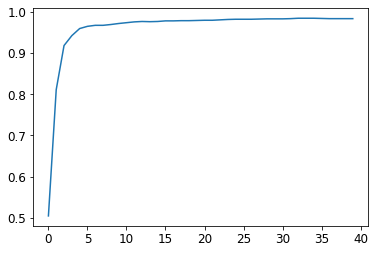

In [289]:
plt.plot(L(learn.recorder.values).itemgot(2))

In [290]:
learn.recorder.values[-1][2]

0.982826292514801

In [292]:
dls = ImageDataLoaders.from_folder(path)
learn = vision_learner(dls, 
                       resnet18, 
                       pretrained=False,
                       loss_func = F.cross_entropy, 
                       metrics = accuracy)

In [293]:
learn.fit_one_cycle(1, 0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.148121,0.017039,0.996075,00:22
